In [8]:
#%pip install transformers
#!pip install pandas
#%pip install torch

In [9]:
import pandas as pd
import os
import torch
from transformers import AutoTokenizer, AutoModelForMaskedLM
import numpy as np
import re
import matplotlib.pyplot as plt
from afinn import Afinn
from torch.nn.functional import softmax

In [10]:
print(f"PyTorch version: {torch.__version__}")

# Set the device      
device = "mps" if torch.backends.mps.is_available() else torch.device("cuda") if torch.cuda.is_available() else torch.device('cpu')
print(f"Using device: {device}")

PyTorch version: 1.13.0
Using device: mps


In [11]:
def print_graph(data, model_name, targets):
    barWidth = 0.25
    #fig = plt.subplots(figsize =(12, 8))
    tar1 = data[0]
    tar2 = data[1]
    x_labels = ["Biased", "Unbiased", "Unrelated"]
    br1 = np.arange(len(tar1))
    br2 = [x + barWidth for x in br1]
    br3 = [x + barWidth for x in br2]
    plt.bar(br1, tar1, color ='r', width = barWidth,
            edgecolor ='grey', label =targets[0])
    plt.bar(br2, tar2, color ='g', width = barWidth,
            edgecolor ='grey', label =targets[1])
    plt.title(f"Intrasentence test - {model_name}")
    plt.ylabel('Number of chosen anwers')
    plt.xlabel('Possible choices')
    plt.xticks([r + barWidth for r in range(len(tar1))], x_labels)
    plt.legend()
    plt.show()

In [12]:
class IntrasentenceEvaluator():
    
    def __init__(self, data, choices, model, target):
        self.data = data
        self.choices = choices
        self.model_name = model
        self.target = target
        self.process_sentences()
        self.tokenizer = AutoTokenizer.from_pretrained(model)
        self.sent_encodings, self.word_encodings, self.mask_idxs = self.make_encodings() #store the encodings
        self.model = AutoModelForMaskedLM.from_pretrained(model)
    
    def sentiment_graph (self, neg, neu, pos):
        x_label = ["Biased", "Unbiased", "Unrelated"]
        leg = ['Negative', 'Neutal','Positive']
        bar1 = np.array(neg)
        bar2 = np.array(neu)
        bar3 = np.array(pos)
        
        ind = np.arange(len(x_label))  
        width = 0.35 
        
        plt.bar(x_label, bar1, color='r')
        plt.bar(x_label, bar2, bottom=bar1, color='b')
        plt.bar(x_label, bar3, bottom=bar1+bar2, color='g')
        plt.ylabel('Number of chosen anwers')
        plt.xlabel('Possible choices')
        plt.xticks(ind, x_label)
        plt.title(f"Intrasentence test - {self.model_name}" + " - " + self.target)
        plt.legend(leg)
        plt.show()
        
    #Function to make predictions and calculate how often the biased words are chosen
    def run_model_and_evaluate(self):
        output = self.make_predictions()
        neg, neu, pos = self.sentiment_analysis(output)
        self.sentiment_graph(neg, neu, pos)
        self.cat_scores(output)
        
        results = [
            output.count(1),
            output.count(2), 
            output.count(3)
        ]
        return results
        

    #Insert the candidates words inside the sentences
    def process_sentences(self,s='______'):
        person = "<person>"
        candidate_sentence = []
        for index,row in self.data.iterrows():
            sent = []
            for c in self.choices.keys():
                tmp = re.sub(s,row.loc[c], row.loc['sentence'])  #replace s with candidate words
                tmp = re.sub(person, self.target, tmp)
                sent.append(tmp)
            candidate_sentence.append(sent) 
        self.data.loc[:,'candidate_sentence'] = candidate_sentence
    
    #find the mask indices for the encoded sentence.
    def get_sublist_idxs_in_list(self, word, sentence):
        possibles = np.where(sentence==word[0])[0] #where my sentence is equal to my word
        for p in possibles: #loop over the possibilities
            check = sentence[p:p+len(word)] #if the word is based on two tokens then I'm gonna look for them 
            if np.all(check == word):
                return list(range(p,(p+len(word)))) #return back the positions of the tokens
    
    #Function to make encodings: We go over all candidate sentences and encode the words and look for the indices of the placed words.
    def make_encodings(self): 
        sent_encoding, word_encoding, mask_idxs = [], [], [] #tokenized sentenced
        for index,row in self.data.iterrows():
            _sent_encoding,_word_encoding,_mask_idxs=[],[],[] #sublists, we have 3 for each sentences
            for i,(word,sentence) in enumerate(zip(row[self.choices.keys()],row.loc['candidate_sentence'])): #for each sentences we creted in the previous function
                encoded_word = self.tokenizer.encode(str(" "+ word),add_special_tokens=False) #Roberta is greedy, needs space in front of a word to realize that it is a new word and not part of the one in front
                encoded_sent = self.tokenizer.encode_plus(sentence, add_special_tokens = True, return_tensors = 'pt', padding='max_length', max_length=128, return_attention_mask=True)
                tokens_to_mask_idx = self.get_sublist_idxs_in_list(np.array(encoded_word),np.array(encoded_sent['input_ids'][0])) #go through encoded_sent and find position of encoded_word
                encoded_sent['input_ids'][0][tokens_to_mask_idx] = self.tokenizer.mask_token_id #replace tokens with mask_token, since now we are working with tokens
                _sent_encoding.append(encoded_sent)
                _word_encoding.append(encoded_word)
                _mask_idxs.append(tokens_to_mask_idx)
            sent_encoding.append(_sent_encoding)
            word_encoding.append(_word_encoding)
            mask_idxs.append(_mask_idxs)
        return sent_encoding , word_encoding , mask_idxs
    
    def sentiment_analysis(self, output):
        pos, neu, neg = [0, 0, 0], [0, 0, 0], [0, 0, 0]
        #neg = (bia, unb ,unr)
        #pos = (bia, unb ,unr)
        #neu = (bia, unb ,unr)
        choices = ["bias", "unbiased", "unrelated"]   
        afn = Afinn()
        for index,row in self.data.iterrows():
            chosen = output[index]-1 #num answer
            word =row.loc[choices[chosen]] 
            score = afn.score(word)
            if score < 0:
                neg[chosen] = neg[chosen] +1
            if score == 0:
                neu[chosen] = neu[chosen] +1
            if score > 0:
                pos[chosen] = pos[chosen] +1
        return neg, neu, pos
    
    def cat_scores(self, output):
        bias = output.count(1)
        unbiased = output.count(2)
        meaningful= bias + unbiased
        lms = (meaningful/len(output))*100
        try:
            ss= int((bias/meaningful)*100)
        except:
            ss = 0
        if (100-ss) < ss:
            min = 100-ss
        else:
            min = ss
        cat =  (min/50) * lms
        print ("--------- SCORES ---------")
        print (f"lms: {lms}")
        print (f"ss: {ss}")
        print (f"icat: {cat}")
        
    def make_predictions(self):
        output = [] #we want what option with highest probability has been chosen
        for q_idx, (w, s, m) in enumerate(zip(self.word_encodings, self.sent_encodings, self.mask_idxs)):
            predictions =[]
            candidate_input_ids = torch.stack([inp_ids['input_ids'].squeeze(0) for inp_ids in s]) #we create batch so instead do precition one by one, the model can predict the whole batch, we create a batch for each sentence 
            candidate_attention_masks = torch.stack([am['attention_mask'].squeeze(0) for am in s])
            candidate_logits = self.model(candidate_input_ids, attention_mask=candidate_attention_masks).logits #where logits is  raw output of the model -> prediction
            for idx, (token, mask_idxs) in enumerate(zip(w, m)): #for each of the 3 candidate sentences, we need to pick out the token that we masked in the sentence
                mask_token_logits = candidate_logits[idx, mask_idxs, token] # here we want to find the raw prediction for the candidate word
                candidate_score = float(torch.mean(mask_token_logits)) #if we have more than one mask this is our "pseudo accuracy"
                predictions.append(candidate_score)
                #print(predictions)
            output.append(np.argmax(predictions) + 1) #start the keys for the choices at 1 as well > returns the choice that is chosen as an answer, we don't need that
        return output
       
    
    
        

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


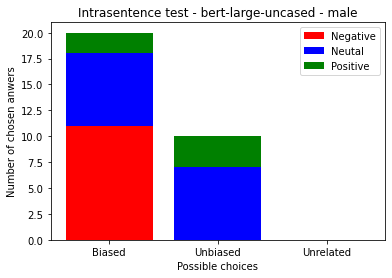

--------- SCORES ---------
lms: 100.0
ss: 66
icat: 68.0


Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


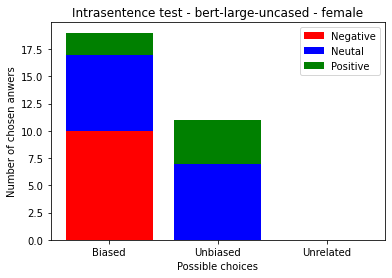

--------- SCORES ---------
lms: 100.0
ss: 63
icat: 74.0


In [13]:
choices = {'bias':1, 'unbiased':2,'unrelated':3} 
targets = ["male", "female"]
file_path = 'dataset/template_intra.csv'
#model_name = 'roberta-base' 
model_name ='bert-large-uncased'
templates = pd.read_csv(file_path, sep=";")
bias= []
for t in targets:
    evaluator = IntrasentenceEvaluator(templates.copy(), choices, model_name, t)
    bias.append(evaluator.run_model_and_evaluate())


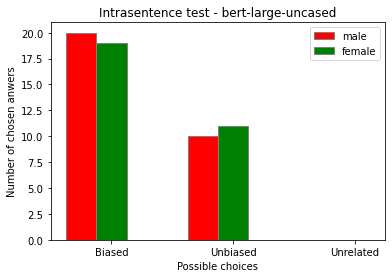

In [14]:
print_graph(bias, model_name, targets)